# ASSIGNMENT 2

## Task 1

### Import libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score
from tqdm import tqdm
import time
import copy

### Data Reading, Exploration and preprocessing

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256,256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

path = '.data/'
train_dataset = datasets.Flowers102(root=path,split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root=path,split='test', transform=transform, download=True)
val_dataset = datasets.Flowers102(root=path,split='val', transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 345M/345M [00:30<00:00, 11.1MB/s]


Extracting .data/flowers-102/102flowers.tgz to .data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 564kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 39.0MB/s]


#### Define consts

In [3]:
# Initialize the model, optimizer, and loss function
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using device: {device}")
criterion = nn.CrossEntropyLoss()
nll_criterion = nn.NLLLoss()
num_epochs = 10

Using device: cuda


### Define Training function

In [4]:
# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc

#### Define Validation function

In [5]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc

#### Training loop

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    writer = SummaryWriter(comment= f'Model {model.__class__.__name__}')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Update learning rate
        scheduler.step(val_loss)

        # Deep copy the model if best accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/Val', val_loss, epoch)
    writer.add_scalar('Accuracy/Val', val_acc, epoch)
    # writer.add_scalar('F1/Val', test_f1, epoch)

    print(f'Best Val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    # Close TensorBoard writer
    writer.close()
    return model

# Deep learning Models Definition


In [7]:
# Define the baseline CNN model
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.BatchNorm2d(32),
                                      nn.Dropout(p=0.3),

                                      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.BatchNorm2d(64),
                                      nn.Dropout(p=0.3),

                                      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      nn.BatchNorm2d(128),
                                      nn.Dropout(p=0.3)
                                      )
        self.fc1 = nn.Sequential(nn.Linear(32 * 32 * 128, 512),
                                 nn.ReLU()
                                 )

        self.output = nn.Linear(512, 102)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.output(x)
        x = F.softmax(x, dim=1)
        return x

BaselineModel()

BaselineModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_

#### Train base model

In [8]:
# Initialize model and training components
base_model = BaselineModel().to(device)
optimizer = optim.SGD(base_model.parameters(), lr=0.001)

base_model = train_model(base_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s]


Train Loss: 4.6250 Acc: 0.0088


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Val Loss: 4.6250 Acc: 0.0088

Epoch 2/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Train Loss: 4.6251 Acc: 0.0069


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


Val Loss: 4.6250 Acc: 0.0098

Epoch 3/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Train Loss: 4.6249 Acc: 0.0127


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


Val Loss: 4.6250 Acc: 0.0108

Epoch 4/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Train Loss: 4.6249 Acc: 0.0137


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Val Loss: 4.6250 Acc: 0.0118

Epoch 5/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Train Loss: 4.6248 Acc: 0.0069


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Val Loss: 4.6250 Acc: 0.0108

Epoch 6/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Train Loss: 4.6248 Acc: 0.0098


Validation: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Val Loss: 4.6250 Acc: 0.0108

Epoch 7/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


Train Loss: 4.6249 Acc: 0.0108


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


Val Loss: 4.6250 Acc: 0.0108

Epoch 8/10
----------


Training: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Train Loss: 4.6248 Acc: 0.0069


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


Val Loss: 4.6250 Acc: 0.0108

Epoch 9/10
----------


Training: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Train Loss: 4.6249 Acc: 0.0078


Validation: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Val Loss: 4.6250 Acc: 0.0108

Epoch 10/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Train Loss: 4.6248 Acc: 0.0147


Validation: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]

Val Loss: 4.6250 Acc: 0.0118

Best Val Acc: 0.011765


## Transfer Learning using VGG

#### Define VGG model

In [9]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.classifier = nn.Sequential(
                        nn.Linear(25088, 512),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),

                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),

                        nn.Linear(256, 102),
                        nn.LogSoftmax(dim=1))

vgg_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 103MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Train VGG

In [10]:
# Initialize model and training components
vgg_model = vgg_model.to(device)

# Define the optimizer
vgg_optimizer = optim.Adam(vgg_model.classifier.parameters(), lr=0.001)
vgg_model = train_model(vgg_model, train_loader, val_loader, criterion, vgg_optimizer, num_epochs=num_epochs)

Epoch 1/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Train Loss: 4.4089 Acc: 0.0667


Validation: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]


Val Loss: 3.3523 Acc: 0.2373

Epoch 2/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]


Train Loss: 2.2215 Acc: 0.4765


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Val Loss: 1.9829 Acc: 0.5088

Epoch 3/10
----------


Training: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Train Loss: 0.7690 Acc: 0.8127


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Val Loss: 1.3835 Acc: 0.6314

Epoch 4/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


Train Loss: 0.3029 Acc: 0.9245


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Val Loss: 1.1604 Acc: 0.6882

Epoch 5/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Train Loss: 0.1369 Acc: 0.9676


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Val Loss: 1.1165 Acc: 0.6892

Epoch 6/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Train Loss: 0.0911 Acc: 0.9794


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Val Loss: 1.0549 Acc: 0.7186

Epoch 7/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Train Loss: 0.0560 Acc: 0.9882


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Val Loss: 0.9693 Acc: 0.7471

Epoch 8/10
----------


Training: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Train Loss: 0.0256 Acc: 0.9961


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Val Loss: 0.9919 Acc: 0.7412

Epoch 9/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


Train Loss: 0.0172 Acc: 0.9980


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Val Loss: 1.1009 Acc: 0.7216

Epoch 10/10
----------


Training: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]


Train Loss: 0.0167 Acc: 0.9971


Validation: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]

Val Loss: 0.9665 Acc: 0.7500

Best Val Acc: 0.750000


## Transfer Learning using ResNet-50

#### Define ResNet-50 model

In [11]:
resnet_model = models.resnet50()
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Sequential(
        nn.Linear(2048, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(256, 102),
        nn.LogSoftmax(dim=1)
    )
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Train ResNet-50 model

In [12]:
resnet_model = resnet_model.to(device)
# Define the optimizer
resnet_optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

resnet_model = train_model(resnet_model, train_loader, val_loader, criterion, resnet_optimizer, num_epochs=num_epochs)

Epoch 1/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Train Loss: 4.7423 Acc: 0.0127


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


Val Loss: 4.7969 Acc: 0.0098

Epoch 2/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


Train Loss: 4.5595 Acc: 0.0147


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


Val Loss: 4.5620 Acc: 0.0245

Epoch 3/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]


Train Loss: 4.5184 Acc: 0.0186


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


Val Loss: 4.6000 Acc: 0.0245

Epoch 4/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Train Loss: 4.4913 Acc: 0.0176


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Val Loss: 4.5838 Acc: 0.0235

Epoch 5/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


Train Loss: 4.4771 Acc: 0.0216


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Val Loss: 4.5755 Acc: 0.0216

Epoch 6/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Train Loss: 4.4564 Acc: 0.0245


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Val Loss: 4.5923 Acc: 0.0294

Epoch 7/10
----------


Training: 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


Train Loss: 4.3924 Acc: 0.0353


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.20it/s]


Val Loss: 4.5206 Acc: 0.0392

Epoch 8/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


Train Loss: 4.3480 Acc: 0.0480


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Val Loss: 4.4951 Acc: 0.0422

Epoch 9/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Train Loss: 4.3240 Acc: 0.0559


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Val Loss: 4.4654 Acc: 0.0500

Epoch 10/10
----------


Training: 100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Train Loss: 4.2707 Acc: 0.0637


Validation: 100%|██████████| 32/32 [00:10<00:00,  3.07it/s]

Val Loss: 4.4609 Acc: 0.0471

Best Val Acc: 0.050000


### Model performance evaluation

Baseline model test score

In [13]:
validate(base_model, test_loader, criterion)

Validation: 100%|██████████| 193/193 [00:44<00:00,  4.38it/s]


Val Loss: 4.6251 Acc: 0.0150


(4.625085609136393, tensor(0.0150, device='cuda:0', dtype=torch.float64))

VGG-16 test score

In [14]:
validate(vgg_model, test_loader, criterion)

Validation: 100%|██████████| 193/193 [01:17<00:00,  2.49it/s]

Val Loss: 1.1992 Acc: 0.7053


(1.1992354500090239, tensor(0.7053, device='cuda:0', dtype=torch.float64))

ResNet-50 test score

In [15]:
validate(resnet_model, test_loader, criterion)

Validation: 100%|██████████| 193/193 [01:01<00:00,  3.12it/s]

Val Loss: 4.4377 Acc: 0.0473


(4.43771848486272, tensor(0.0473, device='cuda:0', dtype=torch.float64))

### Conclusion and Possible Improvements

#### DeepLearning Models Performance Analysis

1. **Baseline CNN Model**
- Showed very poor performance with accuracy stagnating around 1% across epochs
- Failed to learn meaningful features, suggesting optimization issues
- Training and validation losses remained nearly constant at ~4.62

2. **VGG16 (Transfer Learning)**
- Though it performed best among the three tested, it shows signs of overfitting with increasing gap between training and validation accuracy

3. **ResNet50**
- Unexpectedly poor performance similar to baseline model
- Accuracy remained around 1% despite the sophisticated architecture
- Suggests potential implementation or training configuration issues

#### Key Insights
- Transfer learning with VGG16 proved most effective, likely due to pre-trained weights and appropriate architecture modifications
- The significant gap between VGG16's training and validation accuracy indicates overfitting
- The poor performance of ResNet50 and baseline CNN suggests fundamental training issues

#### Recommended Improvements

- Add batch normalization layers to the baseline CNN
- Experiment with different dropout rates (current 0.3 might be too high)
- Implement learning rate scheduling (e.g., ReduceLROnPlateau)
- Try different optimizers (current SGD might be sub-optimal; consider Adam or AdamW)
- Increase batch size to stabilize training
- Increase training epochs to more than 10
- Implement cross-validation for more robust evaluation
- Augment training data (random crops, rotations, flips)

**ResNet50 Specific**
- Debug the ResNet50 implementation
- Try unfreezing more layers gradually
- Adjust the classifier head architecture

**Overfitting Mitigation for VGG16**
- Increase dropout rates in classifier layers
- Add L2 regularization
- Implement early stopping
- Reduce model capacity in classifier layers

## Task 2

### Objective

To cluster images of flowers into distinct groups based on their visual features using unsupervised
learning techniques. The goal is to utilize a pre-trained convolutional neural network (CNN) to
extract features from the images and then apply a clustering algorithm to categorize the flowers

### Feature Extraction

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


def perform_elbow_analysis(features, max_clusters=20):
    wcss = []
    k_values = range(1, max_clusters + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, wcss, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

    diffs = np.diff(wcss)
    # Calculate the differences of differences
    diffs_r = np.diff(diffs)
    # Find the elbow point (maximum curvature)
    elbow_point = np.argmax(diffs_r) + 2

    return elbow_point, wcss

In [17]:
# Extract features from the flower images
features = []
for images, _ in train_loader:
    images = images.to(device)
    feature_vectors = vgg_model(images)
    features.append(feature_vectors.detach().cpu().numpy())

features = np.concatenate(features, axis=0)

### Get optimum number of clusters

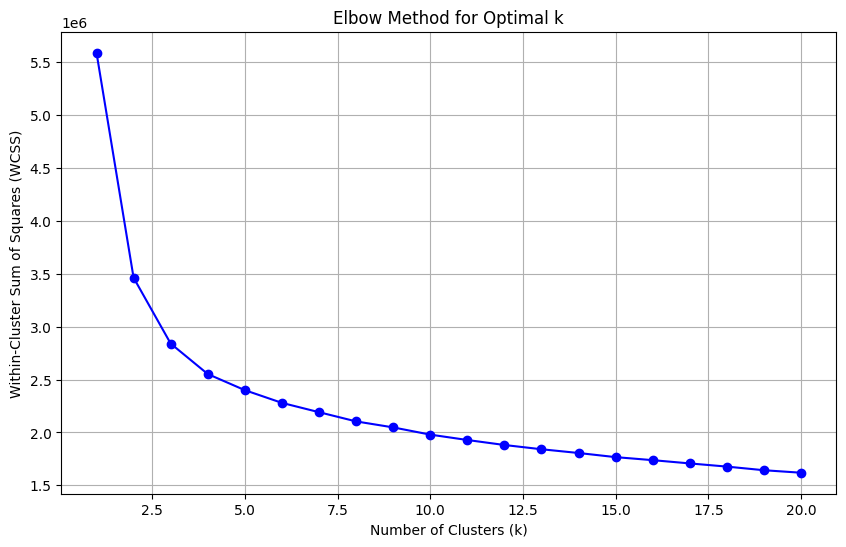

Recommended number of clusters: 2


In [18]:
optimal_k, wcss = perform_elbow_analysis(features)
print(f"Recommended number of clusters: {optimal_k}")

### Clustering: Cluster the extracted features using K-means.

In [19]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Reduce the feature dimensionality using PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

### Clusters visualization

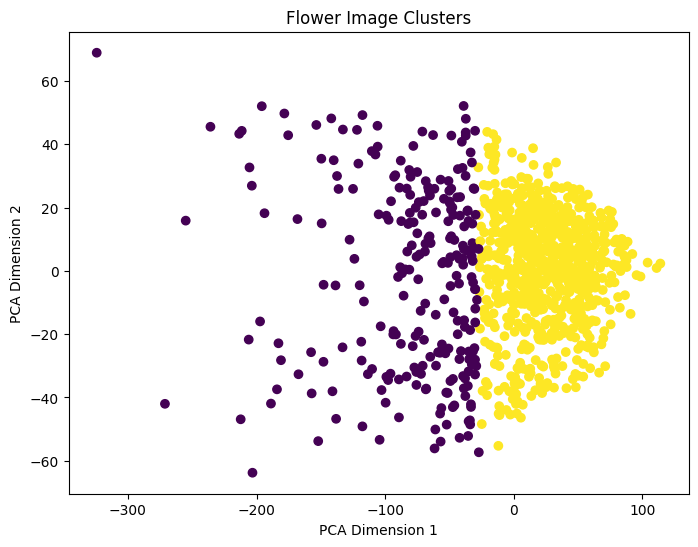

In [20]:

# Plot the clustered data points
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Flower Image Clusters')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()